In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
training_file = r"/content/drive/MyDrive/traffic_sign_dataset/train.p"
testing_file = r"/content/drive/MyDrive/traffic_sign_dataset/test.p"

def load_traffic_sign_data(training_file, testing_file):
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    return train, test

train, test = load_traffic_sign_data(training_file, testing_file)
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']




In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (34799, 32, 32, 3)
X_test shape: (12630, 32, 32, 3)


In [ ]:
# Preprocess features
def preprocess_features(X):
    X_yuv = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:, :, 0] for img in X])
    X_yuv = np.array([cv2.equalizeHist(np.uint8(img)) for img in X_yuv])
    X_yuv = np.expand_dims(X_yuv, axis=-1)
    X_yuv = X_yuv.astype(np.float32)
    X_yuv -= np.mean(X_yuv, axis=0)
    X_yuv /= (np.std(X_yuv, axis=0) + np.finfo('float32').eps)
    return X_yuv
X_train_norm = preprocess_features(X_train)
X_test_norm = preprocess_features(X_test)


#Split train-validation
test_size=0.2
X_train_norm,X_val_norm,y_train,y_val=train_test_split(X_train_norm,y_train,test_size=test_size,random_state=42)

In [ ]:
print(f"Training set size: {len(X_train_norm)}")
print(f"Validation set size: {len(X_val_norm)}")

Training set size: 27839
Validation set size: 6960


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model

# Data Augmentation
image_datagen = ImageDataGenerator(
    rotation_range=30.0,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1
)

# AlexNet Architecture
def alexnet(input_shape, n_classes):
    inputs = Input(shape=input_shape)

    # Adjusted Kernel and Strides to work with 32x32
    x = Conv2D(64, (5, 5), strides=1, activation='relu', padding='same')(inputs)  # Smaller kernel
    x = MaxPooling2D((2, 2), strides=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (5, 5), strides=1, activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=2)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)  # Reduced size
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)  # Reduced size
    x = Dropout(0.5)(x)
    outputs = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define Model
input_shape = (32, 32, 1)  # Works with modified architecture
n_classes = 43
model = alexnet(input_shape, n_classes)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])




In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,033,195 (15.39 MB)

 Trainable params: 4,032,555 (15.38 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Function to evaluate the model
# def evaluate(model, X_data, y_data):
#     loss, accuracy = model.evaluate(X_data, y_data, verbose=0)
#     return accuracy

In [ ]:
# Training Parameters
BATCHSIZE = 128
EPOCHS = 50

# Train Model
history = model.fit(
    image_datagen.flow(X_train_norm, y_train, batch_size=BATCHSIZE),
    validation_data=(X_val_norm, y_val),
    epochs=EPOCHS
)


# Save Model Weights
model.save_weights('alexnet_traffic_sign.weights.h5')
print("Model training complete. Weights saved successfully.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.1204 - loss: 3.4410 - val_accuracy: 0.0489 - val_loss: 7.6894
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.4859 - loss: 1.6598 - val_accuracy: 0.5421 - val_loss: 1.5704
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.7126 - loss: 0.9157 - val_accuracy: 0.9073 - val_loss: 0.3054
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.8304 - loss: 0.5469 - val_accuracy: 0.9369 - val_loss: 0.1878
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.8822 - loss: 0.3846 - val_accuracy: 0.9069 - val_loss: 0.2990
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9111 - loss: 0.2859 - val_accuracy: 0.9701 - val_loss: 0.1053
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9255 - loss: 0.2429 - val_accuracy: 0.9602 - val_loss: 0.1295
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.9371 - loss: 0.2151 -

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Training Parameters
BATCHSIZE = 128
EPOCHS = 50

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    image_datagen.flow(X_train_norm, y_train, batch_size=BATCHSIZE),
    validation_data=(X_val_norm, y_val),
    epochs=50,
    callbacks=[early_stopping]
)
# Save Model Weights
model.save_weights('alexnet_traffic_sign.weights.h5')
print("Model training complete. Weights saved successfully.")

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.9782 - loss: 0.0803 - val_accuracy: 0.9927 - val_loss: 0.0244
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.9777 - loss: 0.0808 - val_accuracy: 0.9866 - val_loss: 0.0414
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9783 - loss: 0.0774 - val_accuracy: 0.9799 - val_loss: 0.0631
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9756 - loss: 0.0875 - val_accuracy: 0.9875 - val_loss: 0.0514
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.9791 - loss: 0.0774 - val_accuracy: 0.9889 - val_loss: 0.0339
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9814 - loss: 0.0682 - val_accuracy: 0.9878 - val_loss: 0.0548
Model training complete. Weights saved successfully.


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9532 - loss: 0.2159
Test Accuracy: 0.9510, Test Loss: 0.2305


In [ ]:
print(f"X_train_norm shape: {X_train_norm.shape}")
print(f"y_train shape: {y_train.shape}")



X_train_norm shape: (27839, 32, 32, 1)
y_train shape: (27839,)


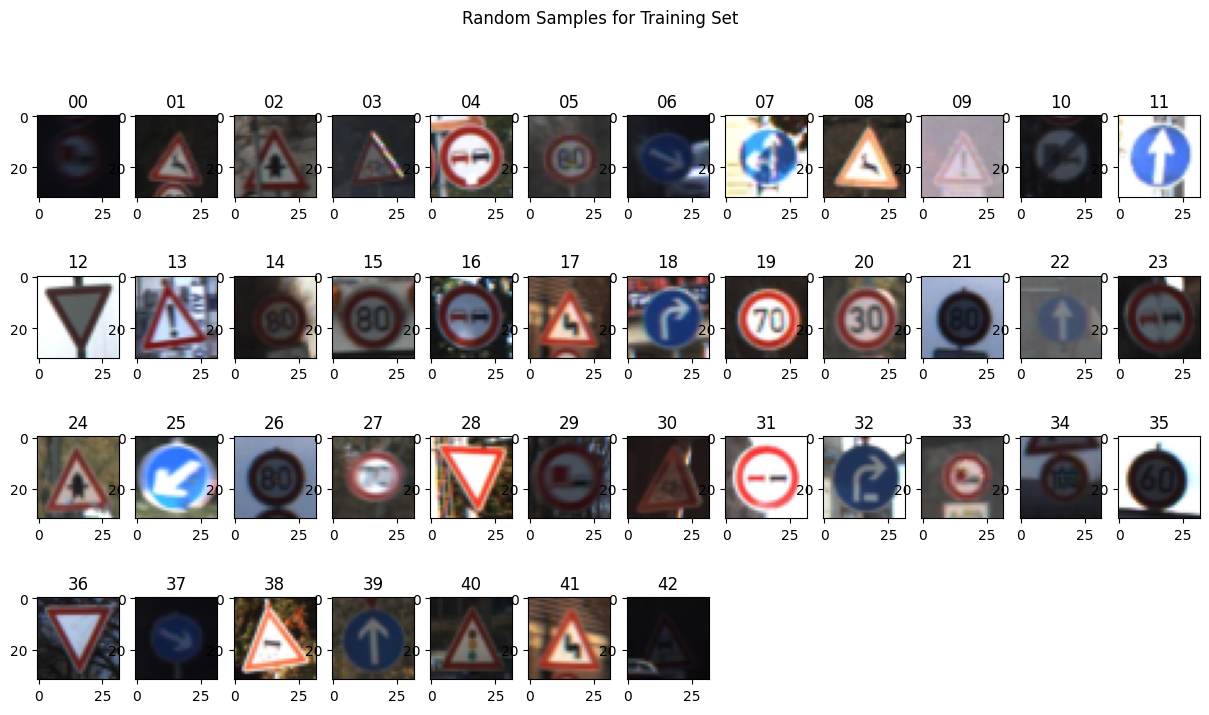

In [ ]:
# Random sampling visualization
rows, cols = 4, 12
fig, ax_array = plt.subplots(rows, cols, figsize=(15, 8))
for class_idx, ax in enumerate(ax_array.ravel()):
    if class_idx < n_classes:
        class_indices = np.where(y_train == class_idx)[0]
        if len(class_indices) == 0:
            ax.axis('off')
            continue
        random_index = np.random.choice(class_indices)
        ax.imshow(X_train[random_index])
        ax.set_title('{:02d}'.format(class_idx))
    else:
        ax.axis('off')
plt.suptitle('Random Samples for Training Set')
plt.show()

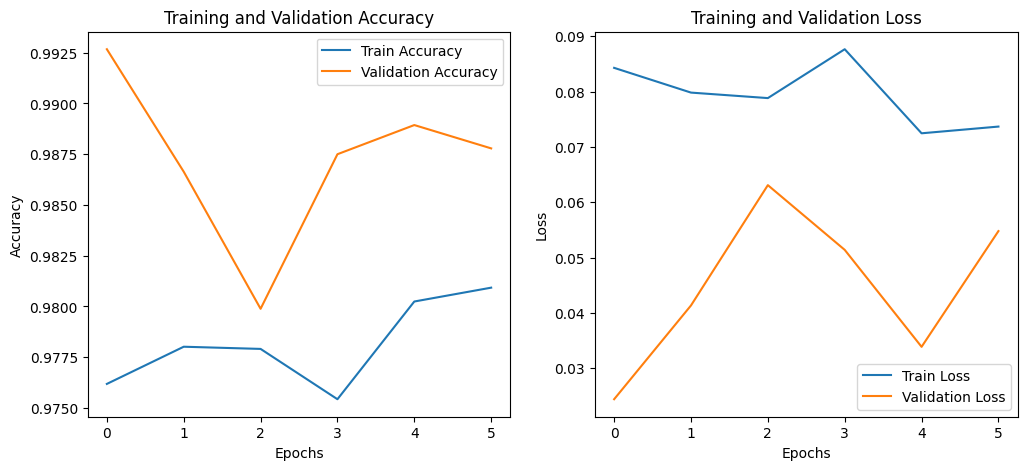

In [ ]:
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

  # Generate accuracy & loss graph
plot_accuracy_loss(history)

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


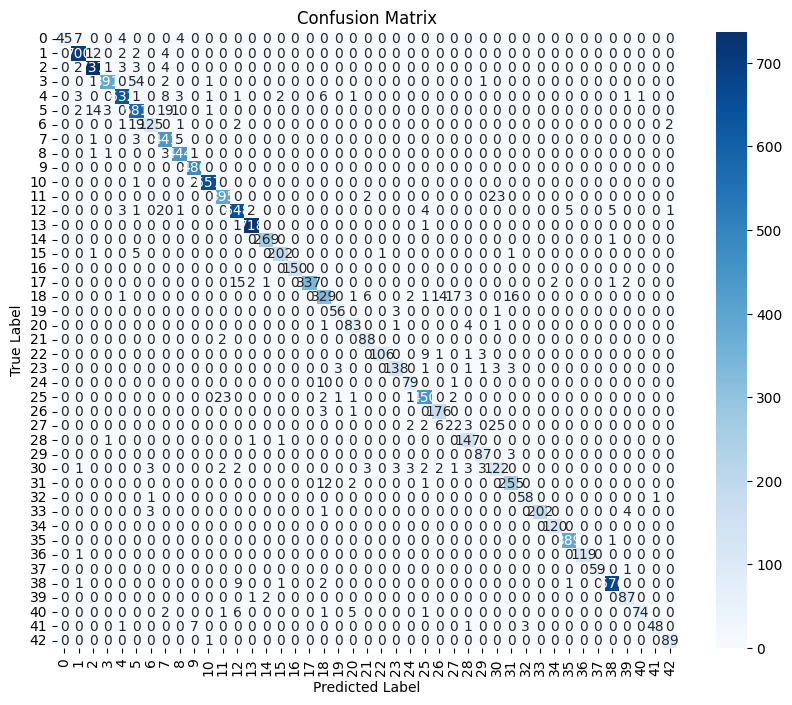

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        60
           1       0.98      0.97      0.97       720
           2       0.96      0.98      0.97       750
           3       0.98      0.87      0.92       450
           4       0.98      0.96      0.97       660
           5       0.87      0.92      0.89       630
           6       0.95      0.83      0.89       150
           7       0.88      0.98      0.93       450
           8       0.95      0.99      0.97       450
           9       0.98      1.00      0.99       480
          10       0.99      1.00      0.99       660
          11       0.93      0.94      0.94       420
          12       0.95      0.94      0.94       690
          13       0.99      1.00      0.99       720
          14       0.99      1.00      0.99       270
          15       0.98      0.96      0.97       210
          16       1.00      1.00      1.00       150
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get model predictions
y_pred_probs = model.predict(X_test_norm)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)   # Convert to class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
y_pred_probs = model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Compare predictions with actual labels
for i in range(10):
    print(f"Actual: {y_test[i]}, Predicted: {y_pred_classes[i]}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Actual: 16, Predicted: 16
Actual: 1, Predicted: 1
Actual: 38, Predicted: 38
Actual: 33, Predicted: 33
Actual: 11, Predicted: 11
Actual: 38, Predicted: 38
Actual: 18, Predicted: 18
Actual: 12, Predicted: 12
Actual: 25, Predicted: 25
Actual: 35, Predicted: 35


395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


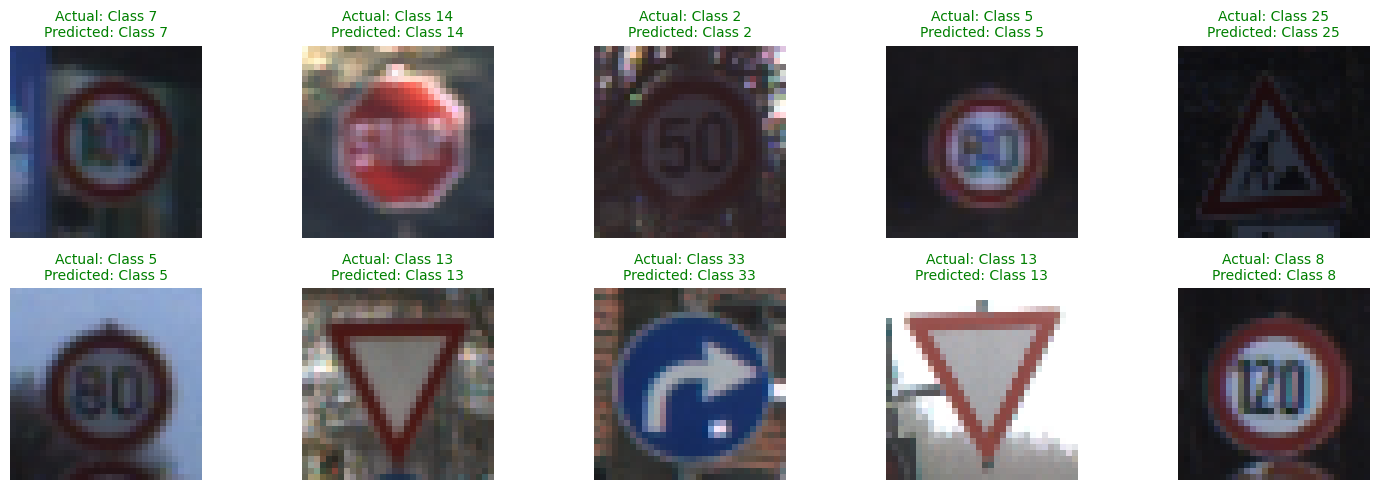

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Class labels (Modify this if your dataset has specific class names)
class_labels = {i: f"Class {i}" for i in range(len(np.unique(y_test)))}

# Get model predictions
y_pred_probs = model.predict(X_test_norm)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)   # Convert to class labels

# Number of images to display
num_images = 10
indices = np.random.choice(len(X_test_norm), num_images, replace=False)  # Randomly select images

# Plot images with actual & predicted labels
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')  # Display image
    actual_label = class_labels[y_test[idx]]
    predicted_label = class_labels[y_pred[idx]]

    # Set title with actual and predicted labels
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10, color='green' if y_test[idx] == y_pred[idx] else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()
